# Testing isostatic boundary conditions in UW2

This is a check to make sure UW2's pressure boundary condition properly works.

The setup is:

     <--------- 100 km ------------>
    _________________________________
    |                               |  ^
    |                               |  |
    |     compressible air          |  50 km 
    |        1 kg.m^-3              |  |
    |                               |  | 
    |_______________________________|  v 
    |        crust                  |  ^ 
    |        500 kg.m^-3            |  25 km 
    |_______________________________|  v 
    |        mantle                 |  ^ 
    |        1000 kg.m^-3           |  25 km 
    |_______________________________|  v 

Now with sedimentation! Sedimentation starts at 0 km, so we should expect
that the mantle level stays at approximately 25 km thick the whole time,
even as the entire crust is replaced

Otherwise, same as before:
We pull each vertical wall at 1 cm/yr (total extension is 2 cm/yr)
The top wall has a free slip boundary (no air can flow in or out of the top)
The bottom wall as a pressure boundary condition

Note: the model does encounter some velocity instabilities, but broadly seems to be correct.
With higher resolution, or smaller timesteps, it might be happier

In [1]:
import underworld as uw
import UWGeodynamics as GEO
import numpy as np
import matplotlib.pyplot as plt

from UWGeodynamics.surfaceProcesses import SedimentationThreshold

loaded rc file /opt/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry
GEO.rcParams['solver'] = "mumps"
GEO.rcParams["surface.pressure.normalization"] = True

# must be 0, because we use compressible air
GEO.rcParams["penalty"] = 0

# Use some higher order elements to get a nicer solution
GEO.rcParams["element.type"] = "Q2/dQ1"

# Use the fancier advection diffusion method
GEO.rcParams["advection.diffusion.method"] = "SLCN"

# Normally this is 0.5, but it can make it easier for the solver if you reduce this number.
GEO.rcParams["CFL"] = 0.25

# Adjust how particles populate the model. Because this model has a big load of inflowing material,
# I like to have these very aggressive
GEO.rcParams["popcontrol.split.threshold"] = 0.95
GEO.rcParams["popcontrol.max.splits"] = 100
GEO.rcParams["popcontrol.particles.per.cell.2D"] = 60
GEO.rcParams["swarm.particles.per.cell.2D"] = 60

In [3]:
GEO.rcParams["output.directory"] = "simple_isos_3"

In [4]:
# This is all for scaling the model
# most of it is pretty self explanitory, try to make them match your setup as best as possible
half_rate = 1.0 * u.centimeter / u.year
model_length = 100e3 * u.meter
model_height = 100e3 * u.meter
refViscosity = 1e22 * u.pascal * u.second
bodyforce = 500 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

In [5]:
# Setup the model domain and resolution. The 'divisor' is just an easy way to adjust the resolution
divisor = 4
Model = GEO.Model(elementRes=(int(100/divisor),int(100/divisor)), 
                  minCoord=(-50 * u.kilometer, -50 * u.kilometer),
                  maxCoord=( 50 * u.kilometer,  50 * u.kilometer))

In [6]:
air      = Model.add_material(name="air", shape=GEO.shapes.Layer2D(top=Model.top, bottom=0.0))
uc       = Model.add_material(name="crust",  shape=GEO.shapes.Layer2D(top=air.bottom, bottom=-25*u.kilometer))
mantle   = Model.add_material(name="mantle",  shape=GEO.shapes.Layer2D(top=uc.bottom, bottom=Model.bottom))
sediment = Model.add_material(name="sediment")

# We use 'easy' numbers here, so the analytical calculation is easier. Notice that the sediment has the same
# density as the crust.
air.density       =    1. * u.kilogram / u.metre**3
sediment.density  =  500. * u.kilogram / u.metre**3
uc.density        =  500. * u.kilogram / u.metre**3
mantle.density    = 1000. * u.kilogram / u.metre**3


air.viscosity      = 1e19 * u.pascal * u.second
uc.viscosity       = 1e21 * u.pascal * u.second  # If you make everything the same viscosity, UW goes a bit wild, so 
mantle.viscosity   = 1e20 * u.pascal * u.second  # by making these different, it gives the solver something to 'do'.
sediment.viscosity = 1e21 * u.pascal * u.second 


# we need to make the air compressible, so we can put a no infow boundary condition on the top of the model
air.compressibility = 1e3  # Not sure what's a good value

In [7]:
# So here we set the threshold to be 0 km. That means when the crust thins, and hence subsides, it is immediately
# replaced by sediment material. We therefor expect by the end of the model to have entirely replaced the crust
# and we should see 25 km of mantle, with 25 km of sediment on top.
Model.surfaceProcesses = GEO.surfaceProcesses.SedimentationThreshold(
    air=[air], 
    sediment=[sediment], 
    threshold=0.*u.kilometer)

In [8]:
# We need to initialise the model before calculating anything to serious (like the lithostatic pressure)
Model.init_model()

# This is where isostasy is imposed. We first calculate the lithostatic pressure along the entire bottom of the model. 
P, bottomPress = Model.get_lithostatic_pressureField()

# Then, since the model is laterally homogenous, we average it, and put it into megapascals
bottomPress = GEO.Dimensionalize(np.average(bottomPress), u.megapascal)


# This is where we apply the boundary conditions. As a rule of thumb, the more information we can give to UW, the happier
# it will be. For example, we could make the top a free slip condition:
#     top=[None , 0. * u.centimetre / u.year]
# but really, we don't care much about the top of the air, so giving 'extra info' in the form of a no-slip condition
# helps UW figure out what's going on.
# Try removing various bits of information to compare how the model performs.
Model.set_velocityBCs(left   = [-1.0 * u.centimetre / u.year, 0 * u.centimetre / u.year], 
                      right  = [1.0 * u.centimetre / u.year,  0 * u.centimetre / u.year], 
                      top    = [0 * u.centimetre / u.year,    0. * u.centimetre / u.year], 
                      bottom = [None,                         bottomPress]) # This is where the pressure boundary is applied.

In [9]:
# This is a bunch of solver options. You can try playing with them, but these should be good enough.
Model.solver = Model.stokes_solver()
Model.solver.options.A11.ksp_rtol=1e-8
Model.solver.options.scr.ksp_rtol=1e-8
Model.solver.options.scr.use_previous_guess = True
Model.solver.options.scr.ksp_set_min_it_converge = 10
Model.solver.options.scr.ksp_type = "cg"
Model.solver.options.main.remove_constant_pressure_null_space=True


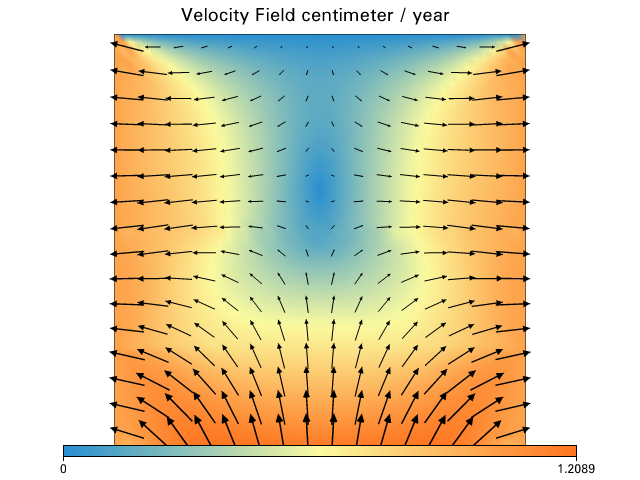


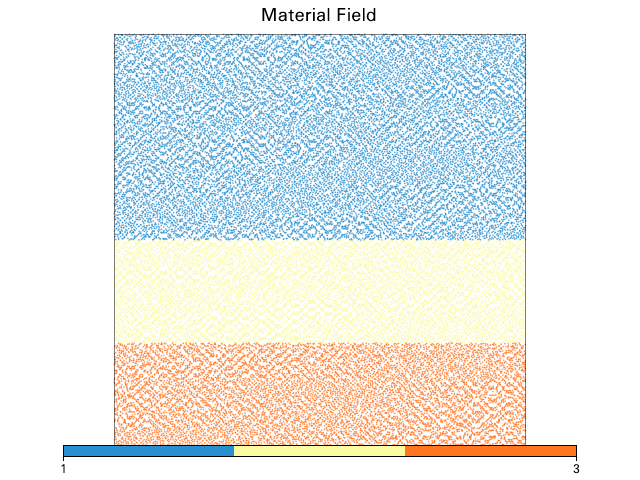

In [10]:
# Do an initial solve to give us a look at what's happening.
Model.solve()
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)

## Run model for 5 Myr increments, and show the results

In [11]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  20679.557625719746 year dt: 20679.55762571975 year (2018-10-25 04:51:00)
Step:2 Model Time:  44066.69148505344 year dt: 23387.13385933369 year (2018-10-25 04:51:00)
Step:3 Model Time:  68200.39951908407 year dt: 24133.70803403062 year (2018-10-25 04:51:01)
Step:4 Model Time:  92188.72918176926 year dt: 23988.3296626852 year (2018-10-25 04:51:01)
Step:5 Model Time:  115845.94754516913 year dt: 23657.218363399857 year (2018-10-25 04:51:01)
Step:6 Model Time:  138896.50243854168 year dt: 23050.554893372562 year (2018-10-25 04:51:02)
Step:7 Model Time:  161513.62522580463 year dt: 22617.12278726294 year (2018-10-25 04:51:02)
Step:8 Model Time:  185126.5690930938 year dt: 23612.94386728919 year (2018-10-25 04:51:02)
Step:9 Model Time:  209354.4958457151 year dt: 24227.926752621315 year (2018-10-25 04:51:03)
Step:10 Model Time:  233714.828533268 year dt: 24360.332687552887 year (2018-10-25 04:51:03)
Step:11

Step:88 Model Time:  2168571.317451838 year dt: 24851.895325002795 year (2018-10-25 04:51:31)
Step:89 Model Time:  2193387.4842776135 year dt: 24816.166825775894 year (2018-10-25 04:51:31)
Step:90 Model Time:  2218209.093471805 year dt: 24821.609194191577 year (2018-10-25 04:51:32)
Step:91 Model Time:  2243083.4782840703 year dt: 24874.384812264903 year (2018-10-25 04:51:32)
Step:92 Model Time:  2267858.3147046315 year dt: 24774.836420561416 year (2018-10-25 04:51:33)
Step:93 Model Time:  2292663.7402051706 year dt: 24805.425500539102 year (2018-10-25 04:51:33)
Step:94 Model Time:  2317513.0746332915 year dt: 24849.334428121085 year (2018-10-25 04:51:33)
Step:95 Model Time:  2342369.2804531585 year dt: 24856.205819866933 year (2018-10-25 04:51:34)
Step:96 Model Time:  2367259.28161109 year dt: 24890.001157931616 year (2018-10-25 04:51:34)
Step:97 Model Time:  2392134.299500685 year dt: 24875.017889595114 year (2018-10-25 04:51:34)
Step:98 Model Time:  2416995.5605514967 year dt: 24861.

Step:175 Model Time:  4330188.705348973 year dt: 24826.84502510098 year (2018-10-25 04:52:03)
Step:176 Model Time:  4354984.969438919 year dt: 24796.26408994542 year (2018-10-25 04:52:03)
Step:177 Model Time:  4379836.276569 year dt: 24851.307130081765 year (2018-10-25 04:52:03)
Step:178 Model Time:  4404653.1689112205 year dt: 24816.89234222022 year (2018-10-25 04:52:04)
Step:179 Model Time:  4429527.952444387 year dt: 24874.783533165963 year (2018-10-25 04:52:04)
Step:180 Model Time:  4454384.524334335 year dt: 24856.57188994887 year (2018-10-25 04:52:04)
Step:181 Model Time:  4479186.493315469 year dt: 24801.968981133417 year (2018-10-25 04:52:05)
Step:182 Model Time:  4504035.126957959 year dt: 24848.63364248999 year (2018-10-25 04:52:05)
Step:183 Model Time:  4528893.616136858 year dt: 24858.489178899108 year (2018-10-25 04:52:06)
Step:184 Model Time:  4553721.757315079 year dt: 24828.141178220656 year (2018-10-25 04:52:06)
Step:185 Model Time:  4578629.835779374 year dt: 24908.07

1


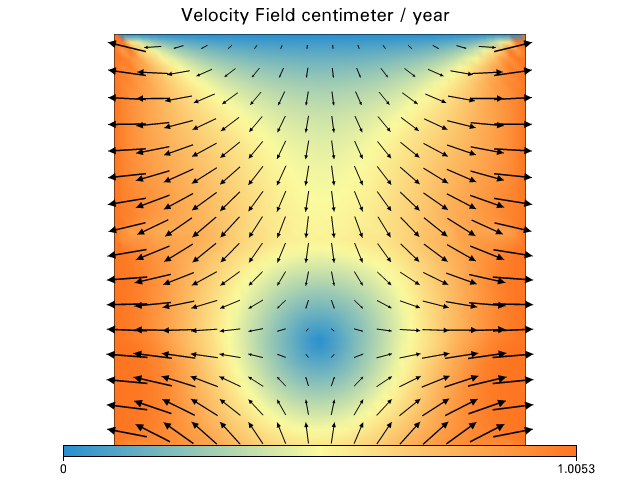


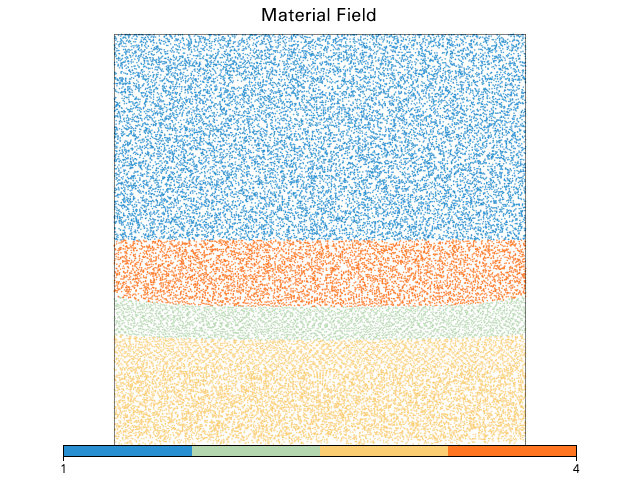

In [12]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)

In [13]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  5024866.193083019 year dt: 24866.193083020855 year (2018-10-25 04:52:15)
Step:2 Model Time:  5049725.626430905 year dt: 24859.433347886683 year (2018-10-25 04:52:15)
Step:3 Model Time:  5074572.828744864 year dt: 24847.202313957794 year (2018-10-25 04:52:15)
Step:4 Model Time:  5099449.421707252 year dt: 24876.592962388047 year (2018-10-25 04:52:16)
Step:5 Model Time:  5124303.611119677 year dt: 24854.189412424777 year (2018-10-25 04:52:16)
Step:6 Model Time:  5149155.248951665 year dt: 24851.63783198832 year (2018-10-25 04:52:17)
Step:7 Model Time:  5173952.039691987 year dt: 24796.790740322573 year (2018-10-25 04:52:17)
Step:8 Model Time:  5198820.059320665 year dt: 24868.019628677604 year (2018-10-25 04:52:17)
Step:9 Model Time:  5223648.209707883 year dt: 24828.150387217986 year (2018-10-25 04:52:18)
Step:10 Model Time:  5248402.8229262065 year dt: 24754.61321832388 year (2018-10-25 04:52:18)
Step

Step:89 Model Time:  7211527.6254597455 year dt: 24779.46652626058 year (2018-10-25 04:52:47)
Step:90 Model Time:  7236364.75161379 year dt: 24837.126154044494 year (2018-10-25 04:52:47)
Step:91 Model Time:  7261210.246351876 year dt: 24845.494738086432 year (2018-10-25 04:52:48)
Step:92 Model Time:  7286082.708536975 year dt: 24872.462185099732 year (2018-10-25 04:52:48)
Step:93 Model Time:  7310974.880237033 year dt: 24892.171700057334 year (2018-10-25 04:52:48)
Step:94 Model Time:  7335838.627674474 year dt: 24863.74743744134 year (2018-10-25 04:52:49)
Step:95 Model Time:  7360737.3208398605 year dt: 24898.693165386903 year (2018-10-25 04:52:49)
Step:96 Model Time:  7385616.790774674 year dt: 24879.46993481334 year (2018-10-25 04:52:49)
Step:97 Model Time:  7410457.651271103 year dt: 24840.8604964287 year (2018-10-25 04:52:50)
Step:98 Model Time:  7435294.93179993 year dt: 24837.28052882703 year (2018-10-25 04:52:50)
Step:99 Model Time:  7460170.968469767 year dt: 24876.036669837536

Step:176 Model Time:  9373685.391838577 year dt: 24848.175212027207 year (2018-10-25 04:53:19)
Step:177 Model Time:  9398546.744236665 year dt: 24861.35239808983 year (2018-10-25 04:53:20)
Step:178 Model Time:  9423406.283091249 year dt: 24859.538854583712 year (2018-10-25 04:53:20)
Step:179 Model Time:  9448295.603666877 year dt: 24889.32057562918 year (2018-10-25 04:53:20)
Step:180 Model Time:  9473169.354334245 year dt: 24873.750667365555 year (2018-10-25 04:53:21)
Step:181 Model Time:  9498020.533495096 year dt: 24851.179160852957 year (2018-10-25 04:53:21)
Step:182 Model Time:  9522878.738895992 year dt: 24858.20540089505 year (2018-10-25 04:53:21)
Step:183 Model Time:  9547788.88849911 year dt: 24910.14960311684 year (2018-10-25 04:53:22)
Step:184 Model Time:  9572668.089194542 year dt: 24879.200695431373 year (2018-10-25 04:53:22)
Step:185 Model Time:  9597540.558732396 year dt: 24872.46953785387 year (2018-10-25 04:53:23)
Step:186 Model Time:  9622400.707280789 year dt: 24860.1

1


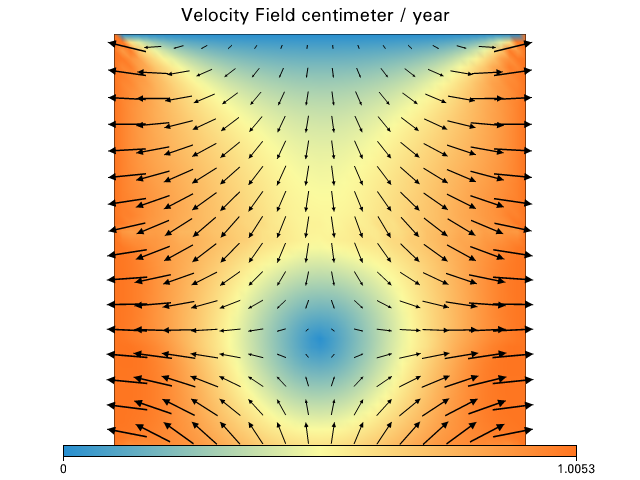


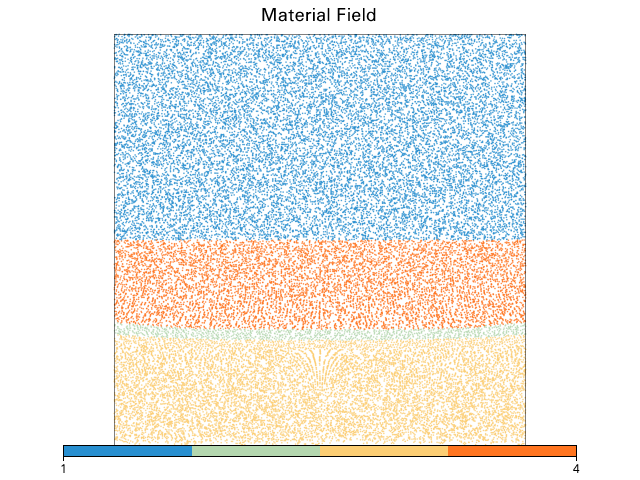

In [14]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)

In [15]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  10024856.761243813 year dt: 24856.761243816356 year (2018-10-25 04:53:31)
Step:2 Model Time:  10049733.006901426 year dt: 24876.2456576139 year (2018-10-25 04:53:32)
Step:3 Model Time:  10074520.647845548 year dt: 24787.64094412031 year (2018-10-25 04:53:32)
Step:4 Model Time:  10099310.577630958 year dt: 24789.92978540914 year (2018-10-25 04:53:32)
Step:5 Model Time:  10124194.645364037 year dt: 24884.067733079864 year (2018-10-25 04:53:33)
Step:6 Model Time:  10149013.793410111 year dt: 24819.148046073853 year (2018-10-25 04:53:33)
Step:7 Model Time:  10173847.281705294 year dt: 24833.48829518351 year (2018-10-25 04:53:34)
Step:8 Model Time:  10198749.44129017 year dt: 24902.159584876295 year (2018-10-25 04:53:34)
Step:9 Model Time:  10223642.5088946 year dt: 24893.067604429823 year (2018-10-25 04:53:34)
Step:10 Model Time:  10248514.754717678 year dt: 24872.24582307982 year (2018-10-25 04:53:35)
St

Step:88 Model Time:  12186829.566587567 year dt: 24852.136792865498 year (2018-10-25 04:54:03)
Step:89 Model Time:  12211697.10757315 year dt: 24867.540985582862 year (2018-10-25 04:54:03)
Step:90 Model Time:  12236607.342293631 year dt: 24910.23472048145 year (2018-10-25 04:54:04)
Step:91 Model Time:  12261446.905055141 year dt: 24839.562761510457 year (2018-10-25 04:54:04)
Step:92 Model Time:  12286306.46761122 year dt: 24859.562556079098 year (2018-10-25 04:54:04)
Step:93 Model Time:  12311203.186851649 year dt: 24896.719240427345 year (2018-10-25 04:54:05)
Step:94 Model Time:  12336002.777657995 year dt: 24799.59080634788 year (2018-10-25 04:54:05)
Step:95 Model Time:  12360865.962051129 year dt: 24863.18439313402 year (2018-10-25 04:54:06)
Step:96 Model Time:  12385719.259732038 year dt: 24853.297680908934 year (2018-10-25 04:54:06)
Step:97 Model Time:  12410566.30420622 year dt: 24847.044474182385 year (2018-10-25 04:54:06)
Step:98 Model Time:  12435402.956914665 year dt: 24836.6

Step:175 Model Time:  14348948.714257374 year dt: 24849.52871981764 year (2018-10-25 04:54:35)
Step:176 Model Time:  14373801.082513573 year dt: 24852.368256197704 year (2018-10-25 04:54:35)
Step:177 Model Time:  14398640.667771887 year dt: 24839.585258314513 year (2018-10-25 04:54:36)
Step:178 Model Time:  14423511.498079771 year dt: 24870.83030788248 year (2018-10-25 04:54:36)
Step:179 Model Time:  14448382.34630024 year dt: 24870.848220470252 year (2018-10-25 04:54:36)
Step:180 Model Time:  14473247.702452214 year dt: 24865.35615197445 year (2018-10-25 04:54:37)
Step:181 Model Time:  14498016.69018449 year dt: 24768.987732275695 year (2018-10-25 04:54:37)
Step:182 Model Time:  14522828.603539966 year dt: 24811.913355475423 year (2018-10-25 04:54:38)
Step:183 Model Time:  14547678.372772612 year dt: 24849.76923264483 year (2018-10-25 04:54:38)
Step:184 Model Time:  14572538.638944712 year dt: 24860.266172100582 year (2018-10-25 04:54:38)
Step:185 Model Time:  14597393.146745324 year 

1


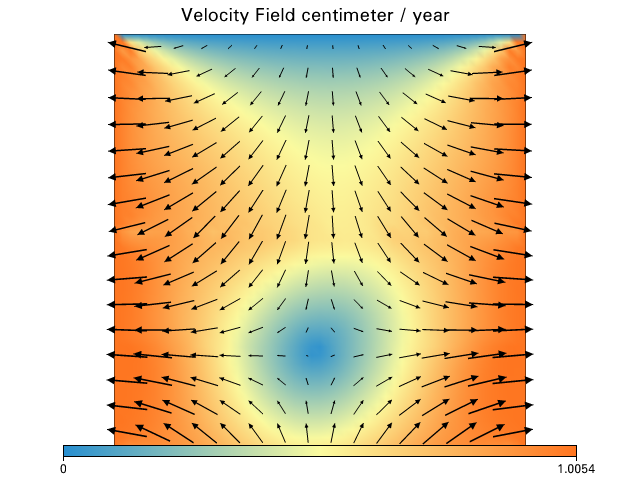


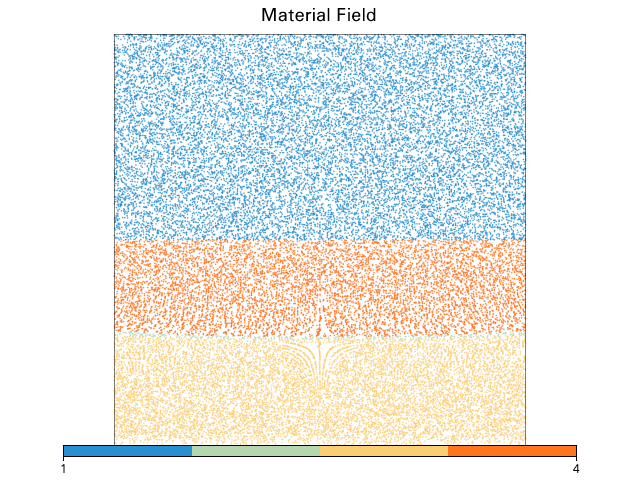

In [16]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)

In [17]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  15024874.374949785 year dt: 24874.374949791123 year (2018-10-25 04:54:47)
Step:2 Model Time:  15049724.087657306 year dt: 24849.712707520743 year (2018-10-25 04:54:48)
Step:3 Model Time:  15074581.058801131 year dt: 24856.971143824223 year (2018-10-25 04:54:48)
Step:4 Model Time:  15099429.866963571 year dt: 24848.80816243863 year (2018-10-25 04:54:49)
Step:5 Model Time:  15124279.595913617 year dt: 24849.72895004673 year (2018-10-25 04:54:49)
Step:6 Model Time:  15149155.090799568 year dt: 24875.49488595011 year (2018-10-25 04:54:49)
Step:7 Model Time:  15174004.42577893 year dt: 24849.334979360956 year (2018-10-25 04:54:50)
Step:8 Model Time:  15198876.400126813 year dt: 24871.974347885705 year (2018-10-25 04:54:50)
Step:9 Model Time:  15223717.219307726 year dt: 24840.81918091299 year (2018-10-25 04:54:50)
Step:10 Model Time:  15248542.77605784 year dt: 24825.55675011167 year (2018-10-25 04:54:51)


Step:88 Model Time:  17186644.09573372 year dt: 24823.636653534864 year (2018-10-25 04:55:20)
Step:89 Model Time:  17211536.356185433 year dt: 24892.260451715967 year (2018-10-25 04:55:20)
Step:90 Model Time:  17236425.843427315 year dt: 24889.487241883628 year (2018-10-25 04:55:21)
Step:91 Model Time:  17261279.129790712 year dt: 24853.28636339497 year (2018-10-25 04:55:21)
Step:92 Model Time:  17286145.57422164 year dt: 24866.444430930664 year (2018-10-25 04:55:21)
Step:93 Model Time:  17311013.70999986 year dt: 24868.13577821691 year (2018-10-25 04:55:22)
Step:94 Model Time:  17335880.649606682 year dt: 24866.93960682465 year (2018-10-25 04:55:22)
Step:95 Model Time:  17360753.438514683 year dt: 24872.788908002105 year (2018-10-25 04:55:23)
Step:96 Model Time:  17385604.35241551 year dt: 24850.91390082317 year (2018-10-25 04:55:23)
Step:97 Model Time:  17410424.091530923 year dt: 24819.739115415094 year (2018-10-25 04:55:23)
Step:98 Model Time:  17435268.957420263 year dt: 24844.865

Step:175 Model Time:  19348779.05450434 year dt: 24806.06529408009 year (2018-10-25 04:55:52)
Step:176 Model Time:  19373575.115910497 year dt: 24796.061406161603 year (2018-10-25 04:55:53)
Step:177 Model Time:  19398454.70560324 year dt: 24879.589692742236 year (2018-10-25 04:55:53)
Step:178 Model Time:  19423320.199043013 year dt: 24865.49343977244 year (2018-10-25 04:55:54)
Step:179 Model Time:  19448198.89059519 year dt: 24878.691552179484 year (2018-10-25 04:55:54)
Step:180 Model Time:  19473026.77622966 year dt: 24827.885634473016 year (2018-10-25 04:55:54)
Step:181 Model Time:  19497842.272485368 year dt: 24815.496255703463 year (2018-10-25 04:55:55)
Step:182 Model Time:  19522681.352436006 year dt: 24839.079950638505 year (2018-10-25 04:55:55)
Step:183 Model Time:  19547466.606931534 year dt: 24785.2544955268 year (2018-10-25 04:55:55)
Step:184 Model Time:  19572334.388203606 year dt: 24867.781272074062 year (2018-10-25 04:55:56)
Step:185 Model Time:  19597201.42255577 year dt:

1


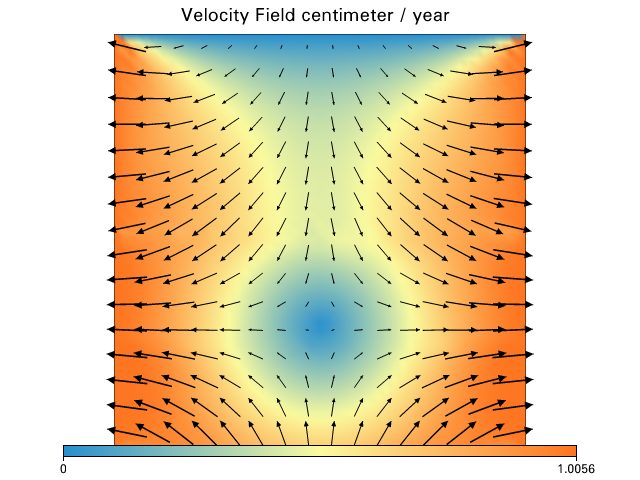


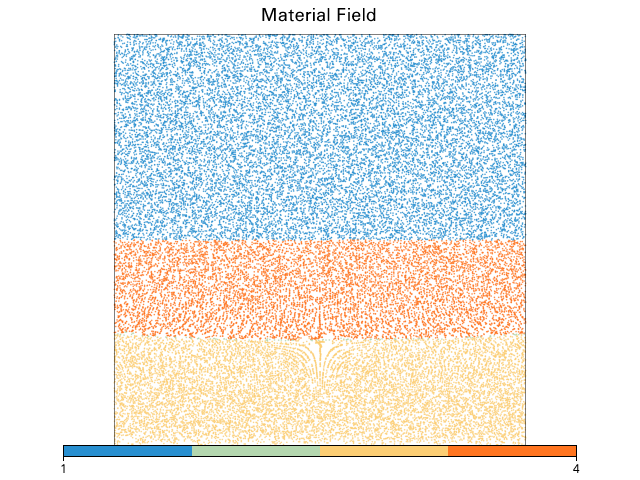

In [18]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)

# Summary

We see the model perform as expected! The sediment effectively replaces the crust, and maintains the mantle thickness of 25km, and by the end, a steady-stake sediment thickness of 25 km. 

## Small issues
We can see the no-slip boundaries on the vertical walls does interfere with the model development, so something to keep in mind.